# AKARI-NEP master catalogue
## Preparation of Spitzer datafusion SERVS data

The Spitzer catalogues are available in `dmu0_NEP-Spitzer`.

In the catalouge, we keep:

- The internal identifier (this one is only in HeDaM data);
- The position;
- The fluxes in aperture 2 (1.9 arcsec); CHECK!
- The “auto” flux (which seems to be the Kron flux);
- The stellarity in each band



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
33f5ec7 (Wed Dec 6 16:56:17 2017 +0000)


In [6]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "nep_ra"
DEC_COL = "nep_dec"

## I - Column selection

In [5]:
imported_columns = OrderedDict({
        'nep_id': "nep_id",
        'ra': "nep_ra",
        'dec': "nep_dec",
        'm_irac_i1': "m_irac_i1",
        'merr_irac_i1': "merr_irac_i1",
        'm_ap2_irac_i1': "m_ap_irac_i1",
        'merr_ap2_irac_i1': "merr_ap_irac_i1",
        'm_irac_i2': "m_irac_i2",
        'merr_irac_i2': "merr_irac_i2",
        'm_ap2_irac_i2': "m_ap_irac_i2",
        'merr_ap2_irac_i2': "merr_ap_irac_i2",
        'irac_stellarity': "irac_stellarity",
    })


catalogue = Table.read("../../dmu0/dmu0_NEP-Spitzer/data/NEP-Spitzer-APJ.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2017 #Paper year

# Clean table metadata
catalogue.meta = None

In [7]:
# Adding magnitude and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        errcol = "merr{}".format(col[1:])
        
        catalogue[col][catalogue[col] > 90.] = np.nan
        catalogue[errcol][catalogue[errcol] > 90.] = np.nan
        
        flux, error = mag_to_flux(
            np.array(catalogue[col]), np.array(catalogue[errcol]))
        # Note that some fluxes are 0.
        
        catalogue.add_column(Column(flux*1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error*1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))


In [8]:
catalogue[:10].show_in_notebook()

idx,nep_id,nep_ra,nep_dec,m_irac_i1,merr_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,m_irac_i2,merr_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,irac_stellarity,f_irac_i1,ferr_irac_i1,flag_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,f_irac_i2,ferr_irac_i2,flag_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2
0,1,273.7195508,67.6020944,20.0904,0.1119,20.686,0.074,nan,nan,nan,nan,0.87,33.4072,3.44306,False,19.3019,1.31555,nan,nan,False,nan,nan
1,2,273.7079238,67.5936062,21.4044,0.1481,21.3677,0.1263,nan,nan,nan,nan,0.17,9.95956,1.35853,False,10.302,1.19839,nan,nan,False,nan,nan
2,3,273.7080787,67.6001747,20.577,0.121,20.8622,0.0846,nan,nan,nan,nan,0.15,21.3403,2.37827,False,16.4104,1.27869,nan,nan,False,nan,nan
3,4,273.7103561,67.6041043,20.239,0.1054,21.0816,0.1006,nan,nan,nan,nan,0.21,29.134,2.82824,False,13.4079,1.24232,nan,nan,False,nan,nan
4,5,273.7118783,67.6008184,20.1982,0.0969,20.788,0.0799,nan,nan,nan,nan,0.03,30.2496,2.69972,False,17.5711,1.29307,nan,nan,False,nan,nan
5,6,273.7151038,67.5701698,21.1438,0.1157,21.3254,0.122,nan,nan,nan,nan,0.68,12.6613,1.34924,False,10.7112,1.20358,nan,nan,False,nan,nan
6,7,273.7144146,67.5716953,21.3467,0.1788,20.7915,0.0802,nan,nan,nan,nan,0.93,10.5031,1.72967,False,17.5146,1.29375,nan,nan,False,nan,nan
7,8,273.7058254,67.5949433,21.8841,0.278,21.597,0.1528,nan,nan,nan,nan,0.15,6.40265,1.63938,False,8.34065,1.17381,nan,nan,False,nan,nan
8,9,273.703809,67.5960837,21.118,0.1838,21.0088,0.0948,nan,nan,nan,nan,0.13,12.9658,2.19493,False,14.3377,1.25188,nan,nan,False,nan,nan
9,10,273.7027409,67.6027532,20.5699,0.1076,20.7601,0.0781,nan,nan,nan,nan,0.17,21.4803,2.12877,False,18.0285,1.29684,nan,nan,False,nan,nan


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [9]:
SORT_COLS = ['ferr_ap_irac_i1', 'ferr_ap_irac_i2']
FLAG_NAME = "nep_flag_cleaned"

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 380858 sources.
The cleaned catalogue has 380858 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [11]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_AKARI-NEP.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

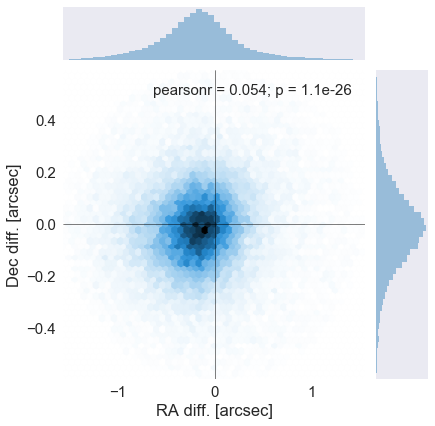

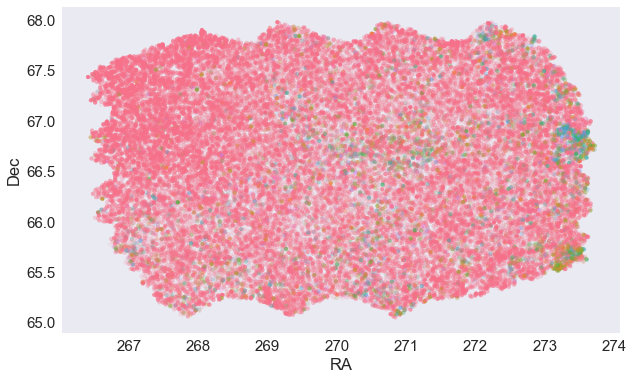

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [13]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.17224358761041003 arcsec
Dec correction: 0.017100100612310598 arcsec


In [15]:
catalogue[RA_COL] = catalogue[RA_COL] + delta_ra.to(u.deg)
catalogue[DEC_COL] = catalogue[DEC_COL] + delta_dec.to(u.deg)

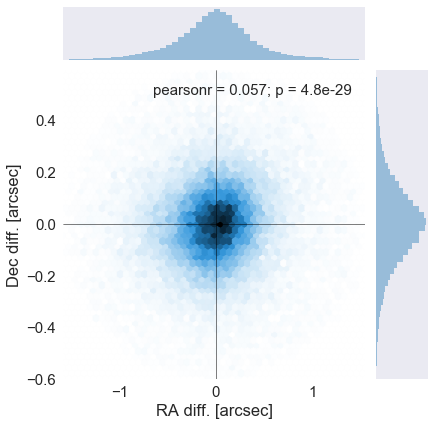

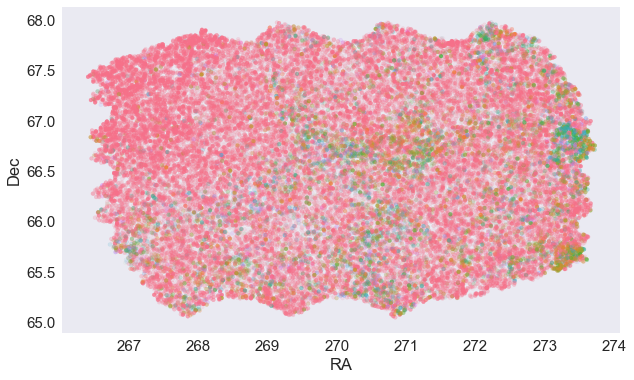

In [16]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [17]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [18]:
GAIA_FLAG_NAME = "nep_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

44067 sources flagged.


## V - Saving to disk

In [19]:
catalogue.write("{}/NEP-Spitzer.fits".format(OUT_DIR), overwrite=True)